Paper: https://papers.nips.cc/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

Reference :  https://github.com/marload/DeepRL-TensorFlow2/blob/master/A2C/A2C_Discrete.py

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

import gym
import argparse
import numpy as np

tf.keras.backend.set_floatx('float64')

    parser.add_argument('--gamma', type=float, default=0.99)
    parser.add_argument('--update_interval', type=int, default=5)
    parser.add_argument('--actor_lr', type=float, default=0.0005)
    parser.add_argument('--critic_lr', type=float, default=0.001)

In [7]:
gamma = 0.99
update_interval = 5
actor_lr = 0.0005
critic_lr = 0.001

In [12]:
class Actor:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(actor_lr)

    def create_model(self):
        return tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])

    def compute_loss(self, actions, logits, advantages):
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        actions = tf.cast(actions, tf.int32)
        policy_loss = ce_loss(
            actions, logits, sample_weight=tf.stop_gradient(advantages))
        return policy_loss

    def train(self, states, actions, advantages):
        with tf.GradientTape() as tape:
            logits = self.model(states, training=True)
            loss = self.compute_loss(
                actions, logits, advantages)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

In [13]:
class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(critic_lr)

    def create_model(self):
        return tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model(states, training=True)
            assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

In [16]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.actor = Actor(self.state_dim, self.action_dim)
        self.critic = Critic(self.state_dim)
        self.rewards = []

    def td_target(self, reward, next_state, done):
        if done:
            return reward
        v_value = self.critic.model.predict(
            np.reshape(next_state, [1, self.state_dim]))
        return np.reshape(reward + gamma * v_value[0], [1, 1])

    def advatnage(self, td_targets, baselines):
        return td_targets - baselines

    def list_to_batch(self, list):
        batch = list[0]
        for elem in list[1:]:
            batch = np.append(batch, elem, axis=0)
        return batch

    def train(self, max_episodes=1000):
        for ep in range(max_episodes):
            state_batch = []
            action_batch = []
            td_target_batch = []
            advatnage_batch = []
            episode_reward, done = 0, False
            
            

            state = self.env.reset()

            while not done:
                # self.env.render()
                probs = self.actor.model.predict(
                    np.reshape(state, [1, self.state_dim]))
                action = np.random.choice(self.action_dim, p=probs[0])

                next_state, reward, done, _ = self.env.step(action)

                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, 1])
                next_state = np.reshape(next_state, [1, self.state_dim])
                reward = np.reshape(reward, [1, 1])

                td_target = self.td_target(reward * 0.01, next_state, done)
                advantage = self.advatnage(
                    td_target, self.critic.model.predict(state))

                state_batch.append(state)
                action_batch.append(action)
                td_target_batch.append(td_target)
                advatnage_batch.append(advantage)

                if len(state_batch) >= update_interval or done:
                    states = self.list_to_batch(state_batch)
                    actions = self.list_to_batch(action_batch)
                    td_targets = self.list_to_batch(td_target_batch)
                    advantages = self.list_to_batch(advatnage_batch)

                    actor_loss = self.actor.train(states, actions, advantages)
                    critic_loss = self.critic.train(states, td_targets)

                    state_batch = []
                    action_batch = []
                    td_target_batch = []
                    advatnage_batch = []

                episode_reward += reward[0][0]
                self.rewards.append(episode_reward)
                state = next_state[0]

            print('EP{} EpisodeReward={}'.format(ep, episode_reward))

In [17]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
agent = Agent(env)
agent.train()

EP0 EpisodeReward=14.0
EP1 EpisodeReward=23.0
EP2 EpisodeReward=17.0
EP3 EpisodeReward=17.0
EP4 EpisodeReward=24.0
EP5 EpisodeReward=16.0
EP6 EpisodeReward=10.0
EP7 EpisodeReward=11.0
EP8 EpisodeReward=17.0
EP9 EpisodeReward=14.0
EP10 EpisodeReward=23.0
EP11 EpisodeReward=93.0
EP12 EpisodeReward=17.0
EP13 EpisodeReward=18.0
EP14 EpisodeReward=26.0
EP15 EpisodeReward=12.0
EP16 EpisodeReward=38.0
EP17 EpisodeReward=17.0
EP18 EpisodeReward=18.0
EP19 EpisodeReward=15.0
EP20 EpisodeReward=41.0
EP21 EpisodeReward=54.0
EP22 EpisodeReward=19.0
EP23 EpisodeReward=35.0
EP24 EpisodeReward=19.0
EP25 EpisodeReward=19.0
EP26 EpisodeReward=17.0
EP27 EpisodeReward=26.0
EP28 EpisodeReward=25.0
EP29 EpisodeReward=12.0
EP30 EpisodeReward=17.0
EP31 EpisodeReward=18.0
EP32 EpisodeReward=34.0
EP33 EpisodeReward=40.0
EP34 EpisodeReward=14.0
EP35 EpisodeReward=47.0
EP36 EpisodeReward=20.0
EP37 EpisodeReward=14.0
EP38 EpisodeReward=16.0
EP39 EpisodeReward=14.0
EP40 EpisodeReward=17.0
EP41 EpisodeReward=40.0
EP

EP328 EpisodeReward=174.0
EP329 EpisodeReward=226.0
EP330 EpisodeReward=116.0
EP331 EpisodeReward=154.0
EP332 EpisodeReward=170.0
EP333 EpisodeReward=162.0
EP334 EpisodeReward=330.0
EP335 EpisodeReward=352.0
EP336 EpisodeReward=152.0
EP337 EpisodeReward=352.0
EP338 EpisodeReward=432.0
EP339 EpisodeReward=192.0
EP340 EpisodeReward=191.0
EP341 EpisodeReward=189.0
EP342 EpisodeReward=137.0
EP343 EpisodeReward=161.0
EP344 EpisodeReward=222.0
EP345 EpisodeReward=132.0
EP346 EpisodeReward=155.0
EP347 EpisodeReward=177.0
EP348 EpisodeReward=120.0
EP349 EpisodeReward=152.0
EP350 EpisodeReward=146.0
EP351 EpisodeReward=145.0
EP352 EpisodeReward=177.0
EP353 EpisodeReward=176.0
EP354 EpisodeReward=376.0
EP355 EpisodeReward=397.0
EP356 EpisodeReward=500.0
EP357 EpisodeReward=247.0
EP358 EpisodeReward=214.0
EP359 EpisodeReward=420.0
EP360 EpisodeReward=307.0
EP361 EpisodeReward=246.0
EP362 EpisodeReward=227.0
EP363 EpisodeReward=261.0
EP364 EpisodeReward=406.0
EP365 EpisodeReward=275.0
EP366 Episod

EP648 EpisodeReward=10.0
EP649 EpisodeReward=11.0
EP650 EpisodeReward=12.0
EP651 EpisodeReward=9.0
EP652 EpisodeReward=11.0
EP653 EpisodeReward=9.0
EP654 EpisodeReward=11.0
EP655 EpisodeReward=9.0
EP656 EpisodeReward=11.0
EP657 EpisodeReward=11.0
EP658 EpisodeReward=12.0
EP659 EpisodeReward=9.0
EP660 EpisodeReward=11.0
EP661 EpisodeReward=11.0
EP662 EpisodeReward=11.0
EP663 EpisodeReward=11.0
EP664 EpisodeReward=10.0
EP665 EpisodeReward=10.0
EP666 EpisodeReward=10.0
EP667 EpisodeReward=11.0
EP668 EpisodeReward=10.0
EP669 EpisodeReward=11.0
EP670 EpisodeReward=10.0
EP671 EpisodeReward=10.0
EP672 EpisodeReward=12.0
EP673 EpisodeReward=11.0
EP674 EpisodeReward=10.0
EP675 EpisodeReward=10.0
EP676 EpisodeReward=10.0
EP677 EpisodeReward=12.0
EP678 EpisodeReward=9.0
EP679 EpisodeReward=11.0
EP680 EpisodeReward=14.0
EP681 EpisodeReward=12.0
EP682 EpisodeReward=9.0
EP683 EpisodeReward=9.0
EP684 EpisodeReward=10.0
EP685 EpisodeReward=11.0
EP686 EpisodeReward=11.0
EP687 EpisodeReward=11.0
EP688 E

EP967 EpisodeReward=500.0
EP968 EpisodeReward=500.0
EP969 EpisodeReward=500.0
EP970 EpisodeReward=500.0
EP971 EpisodeReward=500.0
EP972 EpisodeReward=500.0
EP973 EpisodeReward=500.0
EP974 EpisodeReward=500.0
EP975 EpisodeReward=500.0
EP976 EpisodeReward=500.0
EP977 EpisodeReward=500.0
EP978 EpisodeReward=500.0
EP979 EpisodeReward=500.0
EP980 EpisodeReward=500.0
EP981 EpisodeReward=500.0
EP982 EpisodeReward=500.0
EP983 EpisodeReward=500.0
EP984 EpisodeReward=500.0
EP985 EpisodeReward=500.0
EP986 EpisodeReward=500.0
EP987 EpisodeReward=364.0
EP988 EpisodeReward=409.0
EP989 EpisodeReward=452.0
EP990 EpisodeReward=408.0
EP991 EpisodeReward=260.0
EP992 EpisodeReward=205.0
EP993 EpisodeReward=205.0
EP994 EpisodeReward=220.0
EP995 EpisodeReward=200.0
EP996 EpisodeReward=214.0
EP997 EpisodeReward=226.0
EP998 EpisodeReward=188.0
EP999 EpisodeReward=187.0


In [19]:
import numpy as np
a = np.array(agent.rewards)
np.savetxt('a2c_rewards.txt', a, fmt='%d')
#b = np.loadtxt('test1.txt', dtype=int)
#a == b

Text(0, 0.5, 'Reward')

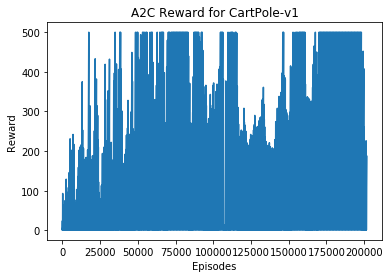

In [22]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt

plt.plot(agent.rewards)
plt.title('A2C Reward for CartPole-v1')
plt.xlabel('Episodes')
plt.ylabel('Reward')